In [1]:
import os
import numpy as np
import shutil
from tqdm import tqdm 

In [ ]:
root_dir = os.path.join('https://drive.google.com/drive/folders/1uodVM4G8UkTFzGnLko5ctYYtw4L5mbs5?usp=drive_link')
work_dir = os.path.join('https://drive.google.com/drive/u/0/my-drive')

##### Делим файлы из первой части на train, val, test и записываем их в каталоги

In [3]:
os.makedirs(os.path.join(root_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(root_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(root_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(work_dir, 'save'), exist_ok=True)

In [4]:
images_list = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

np.random.seed(42)
np.random.shuffle(images_list)
n_files = len(images_list)

# разбиваем список в пропорции train 75%, val 15%, test 10%
n_train = int(0.75 * n_files)
n_val = int(0.15 * n_files)
n_test = n_files - n_train - n_val
train = images_list[: n_train]
val = images_list[n_train : n_train+n_val]
test = images_list[n_train+n_val :]

for file in tqdm(train):
    shutil.copy(os.path.join(root_dir,file),os.path.join(root_dir,'train'))
for file in tqdm(val):
    shutil.copy(os.path.join(root_dir,file),os.path.join(root_dir,'val'))
for file in tqdm(test):
    shutil.copy(os.path.join(root_dir,file),os.path.join(root_dir,'test'))

100%|██████████| 7030/7030 [00:08<00:00, 855.57it/s]


##### Подготовка данных

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class CelebAHeatmapDataset(Dataset):
    def __init__(self, root_dir, file_identity, images_dir='', transform=None):
        self.root_dir = root_dir
        self.images_dir = images_dir
        self.transform = transform
        self.identity_labels = []

        # Список файлов в каталоге images_dir
        images_df = pd.DataFrame([f 
                                  for f in os.listdir(os.path.join(root_dir, images_dir)) 
                                  if os.path.isfile(os.path.join(root_dir, images_dir, f))],
                                    columns=['image'])
        identity_df = pd.read_csv(os.path.join(root_dir, file_identity), names=['image', 'identity'])
        self.identity_labels = identity_df[identity_df.image.isin(images_df.image)]
        self.num_classes = max(self.identity_labels.identity.unique())
        self.identity_labels = self.identity_labels.values.tolist()
    

    def __len__(self):
        return len(self.identity_labels)

    def __getitem__(self, idx):
        # Получаем имя файла и label
        filename = self.identity_labels[idx][0]
        label = self.identity_labels[idx][1]
 
        # Загружаем изображение

        image_path = os.path.join(self.root_dir, self.images_dir, filename)

        image = Image.open(image_path).convert('RGB')

        if self.transform == None:
            image_tensor = None
        else:
            image_tensor = self.transform(image)

        return image_tensor,  torch.tensor(label, dtype=torch.long), filename

In [8]:
train_dataset = CelebAHeatmapDataset(root_dir, 'identity_CelebA.csv', 'train', train_transform)
val_dataset = CelebAHeatmapDataset(root_dir, 'identity_CelebA.csv', 'val', val_transform)
test_dataset = CelebAHeatmapDataset(root_dir, 'identity_CelebA.csv', 'test', test_transform)

##### Обучение модели

In [ ]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

class Learning_model(ABC):
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 save, name_best_model, scheduler=None):
        self.results = {
            'train_loss'   : [],
            'val_loss'     : [],
            'test_loss'     : [],
            'train_accuracy' : [],
            'val_accuracy'   : [],
            'test_accuracy'   : [],
            'best_accuracy'  : 0.0
        }
        self.model           = model
        self.train_loader    = train_loader
        self.val_loader      = val_loader
        self.criterion       = criterion
        self.optimizer       = optimizer
        self.device          = device
        self.epochs          = epochs 
        self.save            = save
        self.name_best_model = name_best_model
        self.scheduler       = scheduler
        
    @abstractmethod
    def _train(self, data_loader):
        # переопределяется для каждого лосса
        pass

    @abstractmethod
    def _val_test(self, data_loader, desc):
        # переопределяется для каждого лосса
        pass

    def fit(self):
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}")
    
            train_loss, train_accuracy = self._train(self.train_loader)
            self.results['train_loss'].append(train_loss)
            self.results['train_accuracy'].append(train_accuracy)

            val_loss, val_accuracy = self._val_test(self.val_loader, "Validating")
            self.results['val_loss'].append(val_loss)
            self.results['val_accuracy'].append(val_accuracy)
            
            print(f"train_loss : {self.results['train_loss'][-1] : .4f}, train_accuracy : {self.results['train_accuracy'][-1]: .4f}", 
                  f'val_loss : {self.results['val_loss'][-1] : .4f}, val_accuracy : {self.results['val_accuracy'][-1]: .4f}')

            if self.results['val_accuracy'][-1] > self.results['best_accuracy']:
                 self.results['best_accuracy'] = self.results['val_accuracy'][-1] 
                 torch.save(self.model.state_dict(), os.path.join(self.save, self.name_best_model))
                 print(f"Saving {self.name_best_model} with accuracy {self.results['val_accuracy'][-1] :.4f}")

            if self.scheduler:
                self.scheduler.step(val_accuracy)
                
    def show_results(self, label='loss', title='CE'):
        labels = {
            'loss'     : ('train loss',     'val loss',     'Loss (MSE)',   'Loss'),
            'accuracy' : ('train accuracy', 'val accuracy', 'Accuracy (%)', 'Accuracy')}
        plt.figure(figsize=(12, 5))
        plt.plot(range(1, self.epochs + 1), self.results['train_'+label], label=labels[label][0])
        plt.plot(range(1, self.epochs + 1), self.results['val_'+label], label=labels[label][1])
        plt.xlabel('Epoch')
        plt.ylabel(labels[label][2])
        plt.title(f'{title} {labels[label][3]}')
        plt.legend()
        plt.grid(True)
    
    def test(self, model_weights, test_loader):
        self.model.load_state_dict(torch.load(model_weights, weights_only=True))

        loss, accuracy = self._val_test(test_loader, "Testing")
        self.results['test_loss'].append(loss)
        self.results['test_accuracy'].append(accuracy)
        print(f"test_loss : {self.results['test_loss'][-1] : .4f}, test_accuracy : {self.results['test_accuracy'][-1]: .4f}")

    

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
num_classes = CelebAHeatmapDataset(root_dir, 'identity_CelebA.csv').num_classes + 1
batch_size = 64
epochs = 30
learning_rate = 1.e-4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### Обучение модели на CE Loss

In [12]:
class CELoss(Learning_model):
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 save, name_best_model, scheduler=None):
        super().__init__(model, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 save, name_best_model, scheduler)

    def _train(self, data_loader):
            self.model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for images, labels, _ in tqdm(data_loader, desc="Training"):
                images, labels = images.to(self.device), labels.to(self.device)            
            
                torch.cuda.empty_cache()
                
                self.optimizer.zero_grad()
                
                outputs = self.model(images)
                self.loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                self.loss.backward()
                self.optimizer.step()
        
                running_loss += self.loss.item() * images.size(0)
                correct_predictions += torch.sum(preds == labels)
                total_samples += images.size(0)

            loss = running_loss / total_samples
            accuracy = (correct_predictions.double() / total_samples).cpu().numpy()
        
            return loss, accuracy
    
    def _val_test(self, data_loader, desc):
            self.model.eval()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            with torch.no_grad():
                for inputs, labels, _ in tqdm(data_loader, desc):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    outputs = self.model(inputs)
                    self.loss = self.criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    running_loss += self.loss.item() * inputs.size(0)

                    correct_predictions += torch.sum(preds== labels)
                    total_samples += inputs.size(0)

                loss = running_loss / total_samples
                accuracy = (correct_predictions.double() / total_samples).cpu().numpy()
                
                return loss, accuracy

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

model_ce = resnet50(weights=ResNet50_Weights.DEFAULT)

# Замена финального слоя
num_ftrs = model_ce.fc.in_features
num_classes = num_classes  
model_ce.fc = nn.Linear(num_ftrs, num_classes)

model_ce = model_ce.to(device)

backbone_params = []
classifier_params = []

for name, param in model_ce.named_parameters():
    if "fc" not in name:
        backbone_params.append(param)  
    else:
        classifier_params.append(param) 

optimizer = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-4},     
    {'params': classifier_params, 'lr': 1e-3}     
])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
criterion = criterion.to(device) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3)

In [14]:
ce = CELoss(model_ce, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 os.path.join(work_dir,'save'),  'ce_best_model_qu.pt', scheduler=scheduler)

In [15]:
ce.fit()

Epoch 1/30


Validating: 100%|██████████| 165/165 [00:35<00:00,  4.71it/s]


train_loss :  7.5675, train_accuracy :  0.0172 val_loss :  6.0752, val_accuracy :  0.0840
Saving ce_best_model_qu.pt with accuracy 0.0840
Epoch 2/30


Validating: 100%|██████████| 165/165 [00:36<00:00,  4.55it/s]


train_loss :  5.4556, train_accuracy :  0.1771 val_loss :  4.4941, val_accuracy :  0.3229
Saving ce_best_model_qu.pt with accuracy 0.3229
Epoch 3/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  4.1808, train_accuracy :  0.3941 val_loss :  3.5756, val_accuracy :  0.5152
Saving ce_best_model_qu.pt with accuracy 0.5152
Epoch 4/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.78it/s]


train_loss :  3.4114, train_accuracy :  0.5550 val_loss :  3.1629, val_accuracy :  0.6118
Saving ce_best_model_qu.pt with accuracy 0.6118
Epoch 5/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.79it/s]


train_loss :  2.9813, train_accuracy :  0.6497 val_loss :  2.9260, val_accuracy :  0.6639
Saving ce_best_model_qu.pt with accuracy 0.6639
Epoch 6/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.76it/s]


train_loss :  2.6802, train_accuracy :  0.7188 val_loss :  2.7882, val_accuracy :  0.6988
Saving ce_best_model_qu.pt with accuracy 0.6988
Epoch 7/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.73it/s]


train_loss :  2.4784, train_accuracy :  0.7659 val_loss :  2.7456, val_accuracy :  0.7177
Saving ce_best_model_qu.pt with accuracy 0.7177
Epoch 8/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  2.3409, train_accuracy :  0.7959 val_loss :  2.7158, val_accuracy :  0.7251
Saving ce_best_model_qu.pt with accuracy 0.7251
Epoch 9/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  2.2420, train_accuracy :  0.8165 val_loss :  2.6825, val_accuracy :  0.7389
Saving ce_best_model_qu.pt with accuracy 0.7389
Epoch 10/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.83it/s]


train_loss :  2.1616, train_accuracy :  0.8365 val_loss :  2.6663, val_accuracy :  0.7459
Saving ce_best_model_qu.pt with accuracy 0.7459
Epoch 11/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  2.0909, train_accuracy :  0.8516 val_loss :  2.6274, val_accuracy :  0.7513
Saving ce_best_model_qu.pt with accuracy 0.7513
Epoch 12/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.74it/s]


train_loss :  2.0401, train_accuracy :  0.8614 val_loss :  2.6071, val_accuracy :  0.7548
Saving ce_best_model_qu.pt with accuracy 0.7548
Epoch 13/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  1.9911, train_accuracy :  0.8728 val_loss :  2.6287, val_accuracy :  0.7574
Saving ce_best_model_qu.pt with accuracy 0.7574
Epoch 14/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  1.9580, train_accuracy :  0.8783 val_loss :  2.6186, val_accuracy :  0.7592
Saving ce_best_model_qu.pt with accuracy 0.7592
Epoch 15/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.79it/s]


train_loss :  1.9186, train_accuracy :  0.8880 val_loss :  2.6044, val_accuracy :  0.7672
Saving ce_best_model_qu.pt with accuracy 0.7672
Epoch 16/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  1.8990, train_accuracy :  0.8905 val_loss :  2.6058, val_accuracy :  0.7616
Epoch 17/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  1.8657, train_accuracy :  0.8967 val_loss :  2.6039, val_accuracy :  0.7677
Saving ce_best_model_qu.pt with accuracy 0.7677
Epoch 18/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.75it/s]


train_loss :  1.8509, train_accuracy :  0.9007 val_loss :  2.6059, val_accuracy :  0.7713
Saving ce_best_model_qu.pt with accuracy 0.7713
Epoch 19/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  1.8326, train_accuracy :  0.9050 val_loss :  2.5960, val_accuracy :  0.7789
Saving ce_best_model_qu.pt with accuracy 0.7789
Epoch 20/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  1.8041, train_accuracy :  0.9097 val_loss :  2.6195, val_accuracy :  0.7751
Epoch 21/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  1.7873, train_accuracy :  0.9141 val_loss :  2.6143, val_accuracy :  0.7838
Saving ce_best_model_qu.pt with accuracy 0.7838
Epoch 22/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.83it/s]


train_loss :  1.7865, train_accuracy :  0.9123 val_loss :  2.5922, val_accuracy :  0.7871
Saving ce_best_model_qu.pt with accuracy 0.7871
Epoch 23/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  1.7699, train_accuracy :  0.9167 val_loss :  2.5549, val_accuracy :  0.7866
Epoch 24/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.76it/s]


train_loss :  1.7458, train_accuracy :  0.9226 val_loss :  2.5971, val_accuracy :  0.7803
Epoch 25/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.79it/s]


train_loss :  1.7546, train_accuracy :  0.9194 val_loss :  2.6560, val_accuracy :  0.7891
Saving ce_best_model_qu.pt with accuracy 0.7891
Epoch 26/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  1.7294, train_accuracy :  0.9242 val_loss :  2.5975, val_accuracy :  0.7949
Saving ce_best_model_qu.pt with accuracy 0.7949
Epoch 27/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  1.7142, train_accuracy :  0.9256 val_loss :  2.5673, val_accuracy :  0.7987
Saving ce_best_model_qu.pt with accuracy 0.7987
Epoch 28/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  1.7021, train_accuracy :  0.9297 val_loss :  2.5587, val_accuracy :  0.8014
Saving ce_best_model_qu.pt with accuracy 0.8014
Epoch 29/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  1.7005, train_accuracy :  0.9297 val_loss :  2.5754, val_accuracy :  0.7975
Epoch 30/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.76it/s]

train_loss :  1.6903, train_accuracy :  0.9316 val_loss :  2.5564, val_accuracy :  0.7948


Testing: 100%|██████████| 110/110 [00:22<00:00,  4.78it/s]


test_loss :  2.5740, test_accuracy :  0.7994


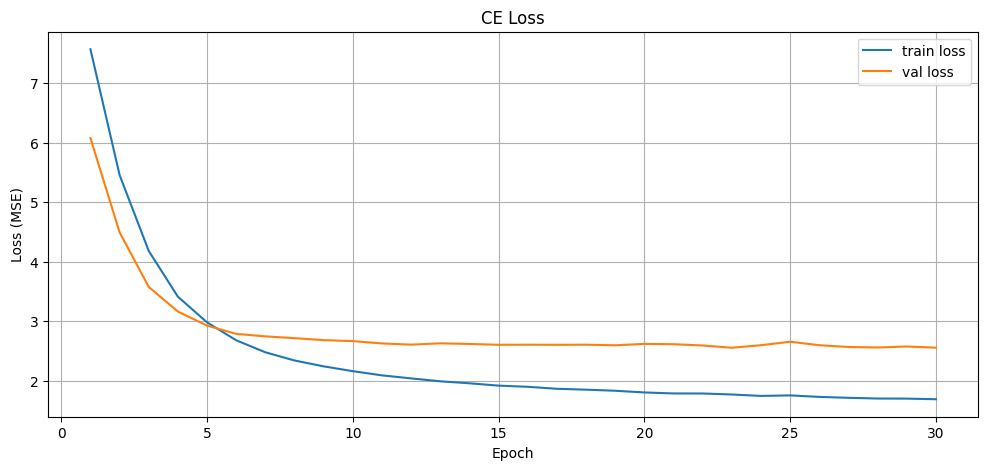

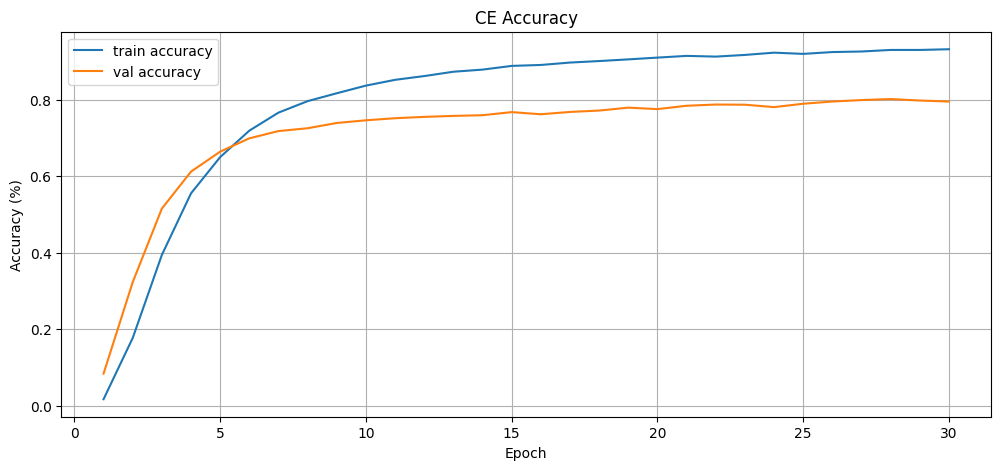

In [16]:
ce.show_results()
ce.show_results(label='accuracy')
ce.test(os.path.join(work_dir, 'save', 'ce_best_model_qu.pt'), test_loader)

##### Удаление СE

In [17]:
del model_ce

##### Обучение модели на ArcFace

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights


class ResNetWithArcFace(nn.Module):
    def __init__(self, num_classes, embedding_size=512, s=30, m=0.5):
        super(ResNetWithArcFace, self).__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_size)
        self.arc_face = ArcFaceLoss(embedding_size, num_classes, s=s, m=m)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        original_logits = F.linear(F.normalize(features), F.normalize(self.arc_face.weight)) * self.arc_face.s
        if labels is None:  
            return original_logits
        else: 
            penalized_logits = self.arc_face(features, labels)
            return penalized_logits, original_logits


In [ ]:

class ArcFaceLoss(nn.Module):
    """
    ArcFace слой
    """
    def __init__(self, in_features, out_features, s=30.0, m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = nn.Parameter(torch.tensor(s, dtype=torch.float32))
        self.m = torch.tensor(m)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = torch.cos(self.m)
        self.sin_m = torch.sin(self.m)
        self.th = torch.cos(torch.pi - self.m)
        self.mm = torch.sin(torch.pi - self.m) * self.m

    def forward(self, input, label):
        x_norm = F.normalize(input, p=2, dim=1, eps=1e-12)
        w_norm = F.normalize(self.weight, p=2, dim=1, eps=1e-12)
        
        cosine = F.linear(x_norm, w_norm)  # cosθ

        # Защита cosθ от выхода за [-1, 1]
        cosine_clipped = torch.clamp(cosine, -1.0, 1.0)
        sine = torch.sqrt(1.0 - cosine_clipped.pow(2))  # sinθ

        # Вычисление cos(θ + m)
        cos_m = torch.cos(self.m)
        sin_m = torch.sin(self.m)
        phi = cosine_clipped * cos_m - sine * sin_m  # cos(θ + m)
        
        # Финальное ограничение phi
        phi = torch.clamp(phi, -1.0, 1.0)
            
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [ ]:
class AFLoss(Learning_model):
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 save, name_best_model, scheduler):
        super().__init__(model, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 save, name_best_model, scheduler)

    def _train(self, data_loader):
            self.model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for images, labels, _ in tqdm(data_loader, desc="Training"):
                images, labels = images.to(self.device), labels.to(self.device)            
            
                torch.cuda.empty_cache()
                
                self.optimizer.zero_grad()
                
                penalized_logits, original_logits = self.model(images, labels) 

                loss = self.criterion(penalized_logits, labels)

                _, preds = torch.max(original_logits, 1)

                loss.backward()
                
                self.optimizer.step()
        
                running_loss += loss.item() * images.size(0)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += images.size(0)
            
            if total_samples == 0:
                total_samples = 1
            
            loss = running_loss / total_samples
            accuracy = correct_predictions / total_samples
        
            return loss, accuracy
    
    def _val_test(self, data_loader, desc="Validation"):
            self.model.eval()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            with torch.no_grad():
                for inputs, labels, _ in tqdm(data_loader, desc=desc):
                  
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    running_loss += loss.item() * inputs.size(0)

                    correct_predictions += torch.sum(preds == labels).item()
                    total_samples += inputs.size(0)

            if total_samples == 0:
                total_samples = 1

            loss = running_loss / total_samples
            accuracy = correct_predictions / total_samples  

            return loss, accuracy


In [ ]:
import torch.nn as nn

model_af = ResNetWithArcFace(num_classes=num_classes, m=0.3)

learning_rate_params = 1e-3
model_af = model_af.to(device)
backbone_params = []
for name, param in model_af.backbone.named_parameters():
    if "fc" not in name:
        backbone_params.append(param)

optimizer = torch.optim.Adam([
    {'params': backbone_params, 'lr': learning_rate},      
    {'params': model_af.backbone.fc.parameters(), 'lr': learning_rate_params},          
    {'params': model_af.arc_face.weight, 'lr': learning_rate_params},         
    {'params': model_af.arc_face.s, 'lr': learning_rate_params},          
], lr=learning_rate_params)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
criterion = criterion.to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5)

In [22]:
af = AFLoss(model_af, train_loader, val_loader, criterion, optimizer, device, epochs, 
                 os.path.join(work_dir,'save'),  'af_best_model.pt', scheduler=scheduler)

In [23]:
af.fit()

Epoch 1/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.75it/s]


train_loss :  15.4149, train_accuracy :  0.0277 val_loss :  5.7098, val_accuracy :  0.1238
Saving af_best_model.pt with accuracy 0.1238
Epoch 2/30


Validating: 100%|██████████| 165/165 [00:38<00:00,  4.25it/s]


train_loss :  12.2111, train_accuracy :  0.2441 val_loss :  3.7444, val_accuracy :  0.4749
Saving af_best_model.pt with accuracy 0.4749
Epoch 3/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.45it/s]


train_loss :  9.8058, train_accuracy :  0.4886 val_loss :  2.9508, val_accuracy :  0.6507
Saving af_best_model.pt with accuracy 0.6507
Epoch 4/30


Validating: 100%|██████████| 165/165 [00:40<00:00,  4.06it/s]


train_loss :  8.3568, train_accuracy :  0.6205 val_loss :  2.6148, val_accuracy :  0.7498
Saving af_best_model.pt with accuracy 0.7498
Epoch 5/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.43it/s]


train_loss :  7.4044, train_accuracy :  0.6924 val_loss :  2.4374, val_accuracy :  0.8002
Saving af_best_model.pt with accuracy 0.8002
Epoch 6/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  6.7575, train_accuracy :  0.7380 val_loss :  2.3119, val_accuracy :  0.8365
Saving af_best_model.pt with accuracy 0.8365
Epoch 7/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.34it/s]


train_loss :  6.2630, train_accuracy :  0.7676 val_loss :  2.2259, val_accuracy :  0.8554
Saving af_best_model.pt with accuracy 0.8554
Epoch 8/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.39it/s]


train_loss :  5.8649, train_accuracy :  0.7906 val_loss :  2.1905, val_accuracy :  0.8670
Saving af_best_model.pt with accuracy 0.8670
Epoch 9/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]


train_loss :  5.5615, train_accuracy :  0.8078 val_loss :  2.1384, val_accuracy :  0.8804
Saving af_best_model.pt with accuracy 0.8804
Epoch 10/30


Validating: 100%|██████████| 165/165 [00:38<00:00,  4.29it/s]


train_loss :  5.3092, train_accuracy :  0.8179 val_loss :  2.1038, val_accuracy :  0.8850
Saving af_best_model.pt with accuracy 0.8850
Epoch 11/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  5.0754, train_accuracy :  0.8298 val_loss :  2.0676, val_accuracy :  0.8862
Saving af_best_model.pt with accuracy 0.8862
Epoch 12/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


train_loss :  4.9034, train_accuracy :  0.8385 val_loss :  2.0381, val_accuracy :  0.8952
Saving af_best_model.pt with accuracy 0.8952
Epoch 13/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


train_loss :  4.7252, train_accuracy :  0.8467 val_loss :  2.0152, val_accuracy :  0.8982
Saving af_best_model.pt with accuracy 0.8982
Epoch 14/30


Validating: 100%|██████████| 165/165 [00:35<00:00,  4.68it/s]


train_loss :  4.5553, train_accuracy :  0.8536 val_loss :  1.9982, val_accuracy :  0.9046
Saving af_best_model.pt with accuracy 0.9046
Epoch 15/30


Validating: 100%|██████████| 165/165 [00:38<00:00,  4.24it/s]


train_loss :  4.4326, train_accuracy :  0.8584 val_loss :  1.9862, val_accuracy :  0.9015
Epoch 16/30


Validating: 100%|██████████| 165/165 [00:38<00:00,  4.33it/s]


train_loss :  4.3180, train_accuracy :  0.8626 val_loss :  1.9714, val_accuracy :  0.9055
Saving af_best_model.pt with accuracy 0.9055
Epoch 17/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  4.2292, train_accuracy :  0.8652 val_loss :  1.9754, val_accuracy :  0.8996
Epoch 18/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  4.1319, train_accuracy :  0.8692 val_loss :  1.9618, val_accuracy :  0.9048
Epoch 19/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  4.0432, train_accuracy :  0.8738 val_loss :  1.9641, val_accuracy :  0.9064
Saving af_best_model.pt with accuracy 0.9064
Epoch 20/30


Validating: 100%|██████████| 165/165 [00:35<00:00,  4.68it/s]


train_loss :  3.9292, train_accuracy :  0.8783 val_loss :  1.9611, val_accuracy :  0.9080
Saving af_best_model.pt with accuracy 0.9080
Epoch 21/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.73it/s]


train_loss :  3.8608, train_accuracy :  0.8799 val_loss :  1.9694, val_accuracy :  0.9053
Epoch 22/30


Validating: 100%|██████████| 165/165 [00:34<00:00,  4.77it/s]


train_loss :  3.7929, train_accuracy :  0.8842 val_loss :  1.9623, val_accuracy :  0.9058
Epoch 23/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.36it/s]


train_loss :  3.7557, train_accuracy :  0.8839 val_loss :  1.9681, val_accuracy :  0.9062
Epoch 24/30


Validating: 100%|██████████| 165/165 [00:37<00:00,  4.37it/s]


train_loss :  3.6584, train_accuracy :  0.8887 val_loss :  1.9684, val_accuracy :  0.9060
Epoch 25/30


Validating: 100%|██████████| 165/165 [00:36<00:00,  4.51it/s]


train_loss :  3.6263, train_accuracy :  0.8892 val_loss :  1.9717, val_accuracy :  0.9065
Epoch 26/30


Validating: 100%|██████████| 165/165 [00:41<00:00,  3.98it/s]


train_loss :  3.5565, train_accuracy :  0.8942 val_loss :  1.9670, val_accuracy :  0.9094
Saving af_best_model.pt with accuracy 0.9094
Epoch 27/30


Validating: 100%|██████████| 165/165 [00:41<00:00,  3.94it/s]


train_loss :  3.5013, train_accuracy :  0.8956 val_loss :  1.9736, val_accuracy :  0.9094
Epoch 28/30


Validating: 100%|██████████| 165/165 [00:40<00:00,  4.07it/s]


train_loss :  3.4552, train_accuracy :  0.8971 val_loss :  1.9823, val_accuracy :  0.9052
Epoch 29/30


Validating: 100%|██████████| 165/165 [00:36<00:00,  4.53it/s]


train_loss :  3.4111, train_accuracy :  0.8976 val_loss :  1.9746, val_accuracy :  0.9045
Epoch 30/30


Validating: 100%|██████████| 165/165 [00:39<00:00,  4.22it/s]

train_loss :  3.3708, train_accuracy :  0.9001 val_loss :  1.9777, val_accuracy :  0.9033


Testing: 100%|██████████| 110/110 [00:24<00:00,  4.51it/s]


test_loss :  2.0043, test_accuracy :  0.9040


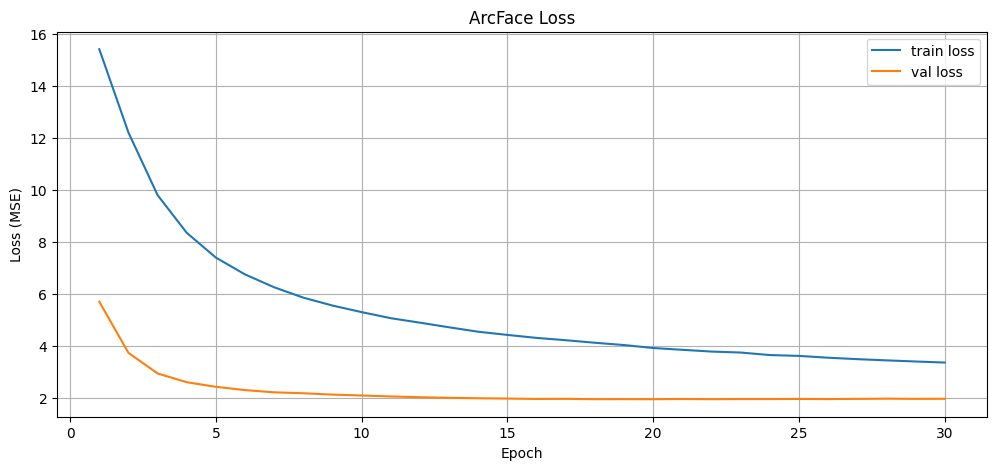

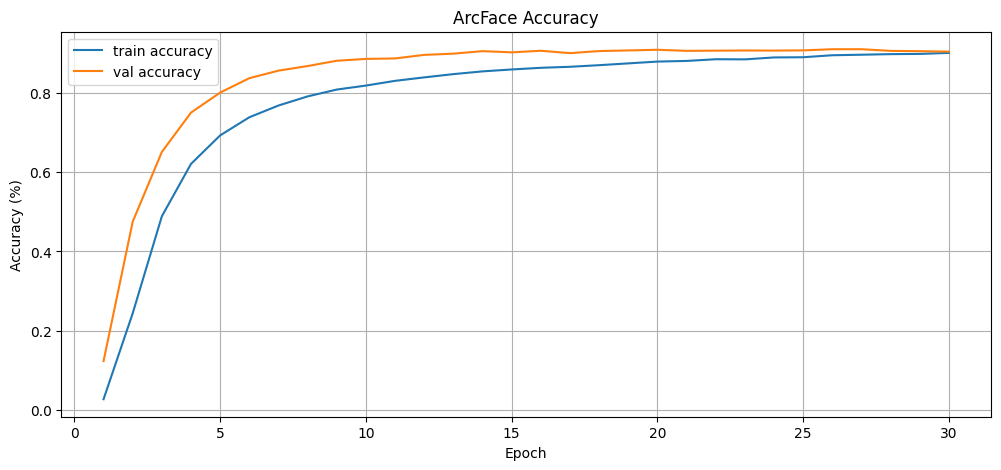

In [24]:
af.show_results(title='ArcFace')
af.show_results(label='accuracy', title='ArcFace')
af.test(os.path.join(work_dir, 'save', 'af_best_model.pt'), test_loader)

##### Отчет

Модели обучались на 30 эпохах. Модель с ArcFaceLoss обучалась дольше.   
Модель с CE Loss за счет перекрытия кластеров различных классов формирует нечеткие границы решений        
Модель с ArcFaceLoss формироует в каждом классе плотные, хорошо отделенные кластеры, а между классами появляется "нейтральная зона".     
В результате чего модель с ArcFaceLoss показала более лучшую сходимость 
и более высокий accuracy  по сравнению с CE Loss.     
 ArcFaceLoss test loss : 2.0043       
 CE Loss test loss     : 2.5740  
          
ArcFaceLoss  test accuracy : 0.9040      
CE Loss test_accuracy      :  0.7994
   